# Faster R-CNN experiments
This file contains experiments for my Faster R-CNN implementation. To access GPUs/TPUs, I ran this file in Google Colaboratory.

## Setup
To pull from the GitHub repository in Colab:
```
%cd drive/MyDrive/Conservation\ Research/Code/counting-cranes
!git add .
!git stash
!git pull
```
----

In [1]:
#Mounting Google Drive...
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Will have to restart runtime after running this cell!
!pip install -r "/content/drive/MyDrive/Conservation Research/Code/counting-cranes/requirements.txt"

     |████████████████████████████████| 2.2MB 24.5MB/s 
     |████████████████████████████████| 17.4MB 174kB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 15.3MB 202kB/s 
     |████████████████████████████████| 11.6MB 49.7MB/s 
     |████████████████████████████████| 808kB 52.1MB/s 
     |████████████████████████████████| 8.3MB 43.7MB/s 
     |████████████████████████████████| 38.2MB 1.3MB/s 
     |████████████████████████████████| 122kB 57.4MB/s 
     |████████████████████████████████| 10.6MB 45.9MB/s 
     |████████████████████████████████| 276kB 53.0MB/s 
     |████████████████████████████████| 829kB 49.4MB/s 
     |████████████████████████████████| 317kB 49.9MB/s 
     |████████████████████████████████| 59.9MB 56kB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 1.3MB 40.8MB/s 
     |████████████████████████████████| 143kB 58.2MB/s 
     |████████████████████████████████| 296kB 59

In [1]:
import json

config = json.load(open('/content/drive/MyDrive/Conservation Research/Code/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_colab']
CODE_FP = config['code_filepath_colab']
MODEL_SAVE_FP = config['model_saves_filepath_colab']
SEED = config['random_seed']
HYPERPARAMETERS = config['faster_rcnn_params']

In [2]:
import sys
import os
sys.path.append(CODE_FP) 
sys.path.append(os.path.join(CODE_FP, 'object_detection'))

from faster_rcnn_model import *
from bird_dataset import *

import torch
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

## Model training
If the Colab runtime disconnects, you'll have to load from a post-epoch `PyTorch Lightning` model save.

In [88]:
#Setting our random seed for all operations (PyTorch, numpy, python.random)
#  especially important if Colab exits the runtime... ensures that we get the same train/val/test split!
seed_everything(SEED);

Global seed set to 1693


In [89]:
#Selecting hyperparams for this run
tile_size = tuple(config['tile_size'])
hyperparams_to_use = ['box_detections_per_img']
hyperparams_to_delete = set(HYPERPARAMETERS['constructor_hyperparams'].keys()) - set(hyperparams_to_use)
for h in hyperparams_to_delete:
  del HYPERPARAMETERS['constructor_hyperparams'][h]
# HYPERPARAMETERS['constructor_hyperparams']['box_nms_thresh'] = 0.3 #TODO: get these into config.json
# HYPERPARAMETERS['constructor_hyperparams']['rpn_nms_thresh'] = 0.8
HYPERPARAMETERS

{'batch_size': 1,
 'constructor_hyperparams': {'box_detections_per_img': 500,
  'box_nms_thresh': 0.3,
  'rpn_nms_thresh': 0.8},
 'iou_threshold_EVALUATION': 0.3,
 'learning_rate': 0.001}

In [90]:
#Creating a dataset and subsetting into train/validation/test splits - run the "seed_everything" directly before this cell!
bird_dataset_train = BirdDataset(root_dir = DATA_FP, 
                                 transforms = get_transforms(train = True), 
                                 tiling_method = 'random', #random tiling for training
                                 num_tiles = 5, 
                                 max_neg_examples = 1, 
                                 tile_size = tile_size)
bird_dataset_eval = BirdDataset(root_dir = DATA_FP, 
                                transforms = get_transforms(train = False), 
                                tiling_method = 'w_o_overlap', #tiling w/o overlap for validation/testing
                                tile_size = tile_size) 

#  here, we limit which PARENT images each set gets to see!
indices = torch.randperm(len(bird_dataset_train)).tolist()
dataset_train = torch.utils.data.Subset(bird_dataset_train, indices[ : 24]) #24 images in train
dataset_val = torch.utils.data.Subset(bird_dataset_eval, indices[24 : 28]) #4 images in val
dataset_test = torch.utils.data.Subset(bird_dataset_eval, indices[28 : ]) #6 images in test

In [91]:
#Wrapping our train/validation/test sets in DataLoaders
dataloader_train = DataLoader(dataset_train, batch_size = HYPERPARAMETERS['batch_size'], shuffle = True, collate_fn = collate_tiles_object_detection) 
dataloader_val = DataLoader(dataset_val, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_object_detection) 
dataloader_test = DataLoader(dataset_test, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_object_detection) 

In [92]:
#Instantiating the pre-trained model and wrapping it in PyTorch Lightning class
model = get_faster_rcnn(num_classes = 2, pretrained = False, **HYPERPARAMETERS['constructor_hyperparams']) #class 0 is reserved for background (may not be necessary) + class 1 is bird class
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'], iou_threshold = HYPERPARAMETERS['iou_threshold_EVALUATION']) #IoU threshold will be used for validation AP!
pl_model; #checking out the model summary - delete ";" if you want to see it!

In [93]:
#Setting up logger 
logging_directory = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'evaluation')
logger = CSVLogger(logging_directory, name = 'initial_training_6.11.2021') #REMEMBER: change this when you shift experiments!

In [94]:
#Training the model w/early stopping on "Val_AP" (remember: we only have one class so this is equivalent to mAP)
checkpoint_dir = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'trainer_checkpoints')

#TODO: nuke the val set (get rid of LR scheduler + early stopping) and see if performance improves...
early_stopping_callback = EarlyStopping(monitor = 'Val_AP', patience = 10, mode = 'max') #makes it so that we don't have to babysit the model as much
lr_callback = LearningRateMonitor(logging_interval = 'step')

trainer = Trainer(gpus = 1, max_epochs = 30, callbacks = [early_stopping_callback, lr_callback], default_root_dir = checkpoint_dir, logger = logger) 
trainer.fit(pl_model, train_dataloader = dataloader_train, val_dataloaders = dataloader_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Global seed set to 1693


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [95]:
#Saving the model
save_name = 'faster_rcnn_nms_hyperparam_shifts_6.11.2021.pth'
torch.save(model.state_dict(), os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name))

## Qualitatively inspecting predictions from the trained model
To avoid memory errors, we have to save and load the model. Make sure to restart the runtime!

In [61]:
#Loading the model
save_name = 'faster_rcnn_not_pretrained_6.11.2021.pth'
model = get_faster_rcnn(num_classes = 2, **HYPERPARAMETERS['constructor_hyperparams'])
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name)))
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate']) 

In [62]:
#Predicting on one parent image - this is currently happening on CPU... prediction w/PyTorch Lightning's trainer seems not to work correctly!
images, targets, _, _ = next(iter(dataloader_test))
images, targets = images[0 : 10], targets[0 : 10] 
preds = pl_model(images)

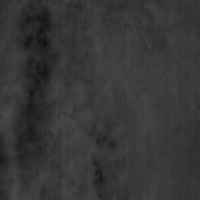

In [72]:
#Plotting an image and predicted bboxes
index = 0
img = np.moveaxis(images[index].numpy(), 0, -1) * 255
bboxes = preds[index]['boxes'].tolist()

pil_img = Image.fromarray(img.astype(np.uint8))
draw = ImageDraw.Draw(pil_img)
for b in bboxes:
    draw.rectangle(b, outline = 'red', width = 1)
pil_img

In [70]:
#Checking counts
print(f'We predicted {len(bboxes)} birds and there are actually {len(targets[index]["boxes"])} birds in this image')

We predicted 3 birds and there are actually 0 birds in this image


## Model testing

In [96]:
#Loading the model
save_name = 'faster_rcnn_nms_hyperparam_shifts_6.11.2021.pth'
model = get_faster_rcnn(num_classes = 2, **HYPERPARAMETERS['constructor_hyperparams']) 
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name)))
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'], iou_threshold = HYPERPARAMETERS['iou_threshold_EVALUATION'])

In [98]:
#Using the saved model and the test set to evaluate (via AP)
trainer = Trainer(gpus = 1)
results = trainer.test(pl_model, test_dataloaders = dataloader_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test_AP': 0.6893546710567143,
 'Test_FP': 1585.0,
 'Test_MAE': 506.8333333333333,
 'Test_RMSE': 835.5753506815927,
 'Test_TP': 6033.0}
--------------------------------------------------------------------------------


## Checking 2018 data allocation

In [ ]:
#Question: are there more 2018 images (which seem more difficult for the model) in the test set than the val set?
imgs = np.array(bird_dataset_train.image_fps)
val_imgs = imgs[indices[24 : 28]]
test_imgs = imgs[indices[28 : ]]
print(val_imgs) #1 2018 image
print()
print(test_imgs) #1 2018 image

['FLIR2_20210321_223145_103_6726.TIF' '20180321_220440_395_1832.tif'
 'FLIR2_20210321_230003_446_7166.TIF' 'FLIR2_20210321_212531_852_5634.TIF']

['FLIR2_20210321_225959_452_7162.TIF' 'FLIR2_20210321_212536_840_5639.TIF'
 'FLIR2_20210321_225458_654_7105.TIF' 'FLIR2_20210321_230002_445_7165.TIF'
 'FLIR2_20210321_204704_024_4313.TIF' '20180321_223204_097_2806.tif']
